In [1]:
import pandas as pd
import seaborn as sns

### Loading

In [2]:
data_path = '../datasets/medicamentos/'
data_file = 'produtos_farmaceuticos.csv'

cols = [81,83]
df = pd.read_csv('{}{}'.format(data_path, data_file), usecols=cols, dtype={0:str, 1:int})
print(df.shape)
df.head(2)

(390341, 2)


,DescricaoProduto,CLEAN
0,GEL ECG E ULTRASON 5KG MERCUR BC 1650 GA,N/I
1,GEL P/ ECG 100GR,7898107240268


### Removendo registros que não possuem o atributo CLEAN

In [3]:
# Removendo rows com EAN nulo
df.dropna(subset=['CLEAN'], inplace=True)
df.shape

(390341, 2)

In [4]:
non_clean = ['N/I','-1','0']
df = df[~df['CLEAN'].isin(non_clean)]
df.shape

(211493, 2)

In [5]:
# Removendo rows em que o EAN não é numérico
df = df[df['CLEAN'].str.isdigit()]
df.shape

(211493, 2)

In [6]:
# Removendo rows com EANs inválidos (conforme regra do cálculo do dígito verificador)
def is_ean_valid(row):
    return not sum(int(d)*i for d,i in zip(row['CLEAN'],[1,3]*7))%10

indices = df.apply(is_ean_valid, axis=1)
df = df[indices]
df.shape

(209000, 2)

### Valores nulos

In [7]:
df[df['DescricaoProduto'].isnull()]

,DescricaoProduto,CLEAN


In [8]:
patt = '^NI\s|^NC\s'  # regex pattern
df[df['DescricaoProduto'].str.contains(patt, regex=True)]

,DescricaoProduto,CLEAN


### UPPER

In [9]:
df['DescricaoProduto'] = df['DescricaoProduto'].str.upper()

### Removendo duplicatas

In [10]:
df.drop_duplicates(subset=['DescricaoProduto'], inplace=True)
df.shape

(59112, 2)

### REMOVER LOTE E VALIDADE

In [11]:
# Removendo informações de lote e validade
pattern = ("[^A-Z0-9]"
           "("
           "LOTE|"
           "LO?T?:|"
           "LO?T(\.|\s)|"
           "LO?T?(\.|\:)\s*[0-9A-Z]+\s*VA?L?(\.|\:)|"
           "VA?L?(\.|\:)\s*[0-9\/A-Z]+\s*LO?T?(\.|\:)|"
           "LO?T?\(.+\)\s*VA?L?\(.+\)|"
           "VA?L?\(.+\)\s*LO?T?\(.+\)|"
           "LO?T?\s*[0-9]+\s*VA?L?\s*[0-9]+"
           ")")
df['DescricaoProduto'] = df['DescricaoProduto'].str.split(pattern, 1).str[0].str.strip()

### Com a remoção do LOTE, novas duplicatas surgiram

In [12]:
df.drop_duplicates(subset=['DescricaoProduto'], inplace=True)
df.shape

(46028, 2)

### Estatísticas

In [13]:
df.count()

DescricaoProduto    46028
CLEAN               46028
dtype: int64

In [14]:
df['CLEAN'].unique().shape

(11284,)

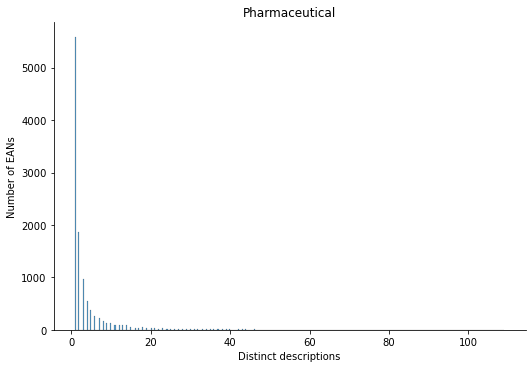

In [15]:
df_grouped = (df.groupby('CLEAN')
              .count()
              .sort_values('DescricaoProduto', ascending=False)
              .reset_index())

facet = sns.displot(data=df_grouped,
                    x='DescricaoProduto',
                    aspect=1.5)
facet.set(xlabel ="Distinct descriptions", 
          ylabel = "Number of EANs", 
          title ='Pharmaceutical')

### Gravando em arquivo

In [16]:
data_file = 'medicamentos.csv'

pd.DataFrame(df).to_csv('{}{}'.format(data_path, data_file), 
                        sep=';', 
                        header=['descricao', 'clean'],
                        index=False,
                        encoding='utf-8')

### Amostragem

In [17]:
dfs = df.sample(100)
print(dfs.count())

DescricaoProduto    100
CLEAN               100
dtype: int64


In [18]:
data_file = 'medicamentos_sample.csv'

dfs.to_csv('{}{}'.format(data_path, data_file),
           sep=';',
           header=['descricao', 'clean'],
           index=False,
           encoding='utf-8')